In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import dill
import sympy
from tqdm import tqdm
from triangle import triangulate
from random import choice, sample
from utils import is_extreme_boundary

### Load precomputed integrals

In [2]:
lagrange_linear_poisson_matrix = dill.load(
    open("../calculations/lagrange_linear_poisson_matrix", "rb")
)
lagrange_linear_poisson_right_values = dill.load(
    open("../calculations/lagrange_linear_poisson_right_values", "rb")
)

lagrange_linear_poisson_matrix_curvilinear = dill.load(
    open("../calculations/lagrange_linear_poisson_matrix_curvilinear", "rb")
)
lagrange_linear_poisson_right_values_curvilinear = dill.load(
    open("../calculations/lagrange_linear_poisson_right_values_curvilinear", "rb")
)

### Initialize the domain

In [47]:
t = np.linspace(0, 2 * np.pi, 16, endpoint=False)

points = np.stack((np.cos(t), np.sin(t))).T

seg = np.array(
    [[j, j + 1] for j in range(points.shape[0] - 1)] + [[points.shape[0] - 1, 0]]
)

### Run triangulation

In [48]:
cndt = triangulate({"vertices": points, "segments": seg}, opts="pq20a0.1neo1s")
points = cndt["vertices"]
triangles = cndt["triangles"]
neighbours = cndt["neighbors"]
vertex_marker_is_boundary = cndt["vertex_markers"]
edges = cndt["edges"]
edge_marker_is_boundary = cndt["edge_markers"]

print(f"Total number of points {points.shape[0]}")

Total number of points 30


## Get boundary triangles

In [49]:
is_boundary_triangle = np.zeros(triangles.shape[0])
for pidx in np.where(vertex_marker_is_boundary)[0]:
    if not is_extreme_boundary(edges, points, edge_marker_is_boundary, pidx)[0]:
        continue
    mask = np.any(triangles == pidx, axis=-1)
    is_boundary_triangle[mask] += 1

is_boundary_triangle = (is_boundary_triangle >= 2)

### Visualize the triangulation

In [50]:
X = dill.load(open("../calculations/hccex", "rb"))
Y = dill.load(open("../calculations/hccey", "rb"))

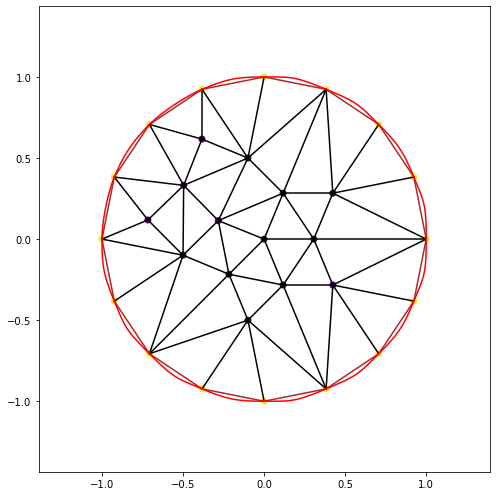

In [51]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(7, 7))
ax.axis("equal")

cl = ["black", "brown"]


for eidx, edge in enumerate(edges):
    ax.plot(
        points[edge][:, 0],
        points[edge][:, 1],
        color=cl[edge_marker_is_boundary[eidx][0]],
    )

ax.scatter(*points.T, c=vertex_marker_is_boundary)

ax.set_xlim([points[:, 0].min() - 1 / 2, points[:, 0].max() + 1 / 2])
ax.set_ylim([points[:, 1].min() - 1 / 2, points[:, 1].max() + 1 / 2])

fig.tight_layout()
plt.tight_layout()

for tidx, _ in enumerate(triangles):
    if is_boundary_triangle[tidx] == True:

        while vertex_marker_is_boundary[_][0] != 0:
            tmp = _[0]
            _[:-1] = _[1:]
            _[-1] = tmp

        tt = np.linspace(0, 1, 100)
        pts = points[_]
        
        l2 = ((pts[1] - pts[0])**2).sum()**0.5
        l3 = ((pts[2] - pts[0])**2).sum()**0.5

        v1x = -pts[1, 1] * l2
        v1y = +pts[1, 0] * l2
        v2x = -pts[2, 1] * l3
        v2y = +pts[2, 0] * l3

        e1_x = X(pts[0, 0], pts[0, 1], pts[1, 0], pts[1, 1], pts[2, 0], pts[2, 1], v1x, v1y, v2x, v2y, tt, 1-tt)
        e1_y = Y(pts[0, 0], pts[0, 1], pts[1, 0], pts[1, 1], pts[2, 0], pts[2, 1], v1x, v1y, v2x, v2y, tt, 1-tt)

        # e2_x = X(0, tt)
        # e2_y = Y(0, tt)

        # e3_x = X(tt, 0)
        # e3_y = Y(tt, 0)

        ax.plot(e1_x, e1_y, color="red")
        # ax.plot(e2_x, e2_y)
        # ax.plot(e3_x, e3_y)
plt.show()

In [52]:
x, y = sympy.symbols("x y")

In [53]:
F = sympy.Float(1)
right_vals = np.zeros((points.shape[0]))
right_vals[:] = sympy.lambdify((x, y), F)(*points.T)

In [54]:
matrix = np.zeros((points.shape[0], points.shape[0]))
b = np.zeros(points.shape[0])

for idx, element in enumerate(tqdm(triangles)):
    x1, x2, x3 = points[element[0], 0], points[element[1], 0], points[element[2], 0]
    y1, y2, y3 = points[element[0], 1], points[element[1], 1], points[element[2], 1]

    if is_boundary_triangle[idx]:
        while vertex_marker_is_boundary[element][0] != 0:
            tmp = element[0]
            element[:-1] = element[1:]
            element[-1] = tmp
            
        pts = points[element]

        l2 = ((pts[1] - pts[0])**2).sum()**0.5
        l3 = ((pts[2] - pts[0])**2).sum()**0.5

        v1x = -pts[1, 1] * l2
        v1y = +pts[1, 0] * l2
        v2x = -pts[2, 1] * l3
        v2y = +pts[2, 0] * l3

        FF = lagrange_linear_poisson_matrix_curvilinear(x1, y1, x2, y2, x3, y3, v1x, v1y, v2x, v2y)
        ff = lagrange_linear_poisson_right_values_curvilinear(x1, y1, x2, y2, x3, y3, v1x, v1y, v2x, v2y, *right_vals[element])
        

        for local_point in range(3):
            if vertex_marker_is_boundary[element[local_point]] == True:
                matrix[element[local_point], element[local_point]] = 1
                b[element[local_point]] *= 0
            else:
                for i in range(3):
                    matrix[element[local_point], element[i]] += 2 * FF[local_point, i]

                b[element[local_point]] -= 2 * ff[local_point]
                
    else:
            
        delta = x1 * y2 - x1 * y3 - x2 * y1 + x2 * y3 + x3 * y1 - x3 * y2

        P_1_x = (-y1 + y3) / delta
        P_1_y = (+x1 - x3) / delta

        P_2_x = (+y1 - y2) / delta
        P_2_y = (-x1 + x2) / delta

        arg = [P_1_x, P_2_x, P_1_y, P_2_y, *right_vals[element]]

        FF = lagrange_linear_poisson_matrix(*arg)
        ff = lagrange_linear_poisson_right_values(*arg)

        for local_point in range(3):
            if vertex_marker_is_boundary[element[local_point]] == True:
                matrix[element[local_point], element[local_point]] = 1
                b[element[local_point]] *= 0
            else:
                for i in range(3):
                    matrix[element[local_point], element[i]] += 2 * FF[local_point, i]

                b[element[local_point]] -= 2 * ff[local_point]

100%|██████████| 42/42 [00:00<00:00, 400.91it/s]


In [55]:
F = np.linalg.solve(matrix, b)

In [56]:
param = np.linspace(0, 1, 20)
tx, ty = np.meshgrid(param, param, indexing="ij")
mask = ty <= 1 - tx
tx = tx[mask]
ty = ty[mask]

In [57]:
XX, YY, ZZ = [], [], []

for idx, element in enumerate(triangles):
    x1, x2, x3 = points[element[0], 0], points[element[1], 0], points[element[2], 0]
    y1, y2, y3 = points[element[0], 1], points[element[1], 1], points[element[2], 1]


    if is_boundary_triangle[idx]:
        while vertex_marker_is_boundary[element][0] != 0:
            tmp = element[0]
            element[:-1] = element[1:]
            element[-1] = tmp
            
        pts = points[element]

        l2 = ((pts[1] - pts[0])**2).sum()**0.5
        l3 = ((pts[2] - pts[0])**2).sum()**0.5

        v1x = -pts[1, 1] * l2
        v1y = +pts[1, 0] * l2
        v2x = -pts[2, 1] * l3
        v2y = +pts[2, 0] * l3

        XX.append(X(pts[0, 0], pts[0, 1], pts[1, 0], pts[1, 1], pts[2, 0], pts[2, 1], v1x, v1y, v2x, v2y, tx, ty))
        YY.append(Y(pts[0, 0], pts[0, 1], pts[1, 0], pts[1, 1], pts[2, 0], pts[2, 1], v1x, v1y, v2x, v2y, tx, ty))
    else:
        XX.append(x1 + tx * (x2 - x1) + ty * (x3 - x1))
        YY.append(y1 + tx * (y2 - y1) + ty * (y3 - y1))



    ZZ.append(F[element[0]]*(1-tx-ty) + F[element[1]]*tx + F[element[2]]*ty)

XX = np.concatenate(XX)
YY = np.concatenate(YY)
ZZ = np.concatenate(ZZ)

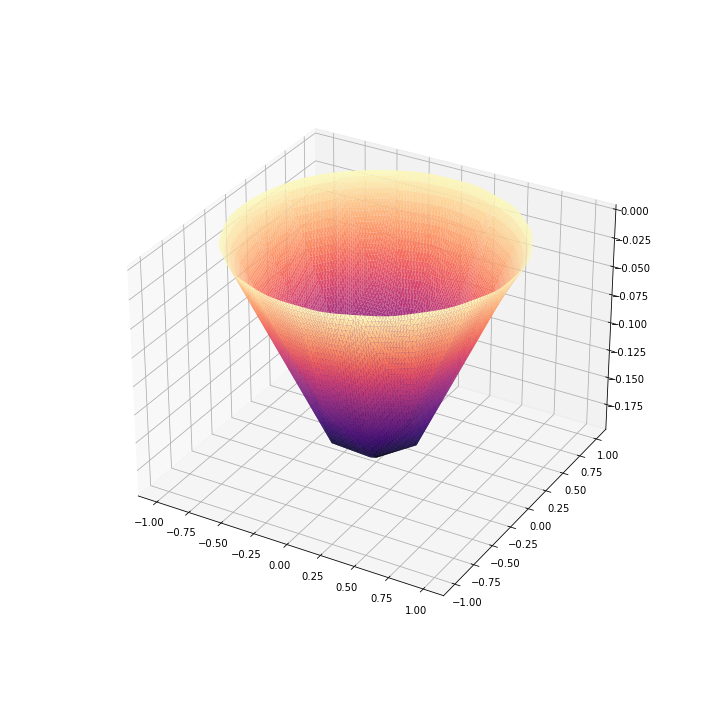

In [58]:
%matplotlib widget
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")
ax.plot_trisurf(XX, YY, ZZ, cmap="magma")
plt.show()

In [60]:
abs(ZZ - (XX**2+YY**2-1)/4).mean()

0.04553106213376863